# ОБУЧЕНИЕ POINTNET СЕТЕЙ ПО КЛАССИФИКАЦИИ НА ОСНОВЕ ОБЛАКОВ ТОЧЕК ВЭКГ

In [1]:
import os
import numpy as np
import itertools
import math, random
from glob import glob
random.seed = 42

from func import *
from model import *

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd

import scipy.spatial.distance
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Демонстрация нормализации (StandardScaler) исходных облаков точек:

In [2]:
file_path = 'final_pointcloud_dataset/train/00002_period_3.csv'
file_path_normalized = 'final_pointcloud_dataset_normalized/train/00002_period_3_normalized.csv'

print('Исходное облако точек:')
# Чтение CSV-файла
df = pd.read_csv(file_path)
point_cloud_array = df[['x', 'y', 'z']].values
pcshow(*point_cloud_array.T)


print('Нормализованное облако точек:')
# Чтение CSV-файла
df_normalized = pd.read_csv(file_path_normalized)
point_cloud_array = df_normalized[['x', 'y', 'z']].values
pcshow(*point_cloud_array.T)

Исходное облако точек:


Нормализованное облако точек:


---

# Преподготовка данных перд обучением сетей:

Кастомные траснсформации датасета:

In [3]:
# Реализация нормального шума
class RandomNoise(object):
    def __init__(self, std=0.002):
        self.std = std
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, self.std, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud


class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

# Реализация нормализации чтобы максильное значение равнялось 1 (схоже с методом в изображениях)
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud


# Создание рандомного семплирования (если точек меньше то просто добавлю дубликаты чтобы добить число)
class PointSampler:
    def __init__(self, num_points=512): 
        self.num_points = num_points

    def __call__(self, pointcloud):
        num_total_points = pointcloud.shape[0]
        
        if num_total_points < self.num_points:
              
            # Семплирование оставшихся точек из уже существующих точек
            sampled_indices = np.random.choice(num_total_points, self.num_points - num_total_points, replace=True)
            duplicated_points = pointcloud[sampled_indices, :]
            
            # Собираем все точки в итоговую выборку
            sampled_points = np.vstack((pointcloud, duplicated_points))
            #print("Всего точек меньше чем надо семплировать - будут дубликаты")
        else:
            # Случайно берем точки:
            sampled_indices = np.random.choice(num_total_points, self.num_points, replace=False)
            sampled_points = pointcloud[sampled_indices, :]
        
        return sampled_points

# Создание рандомного семплирования  с попыткой брать больше точек что дальше лежат от (0,0) 
# (если точек меньше то просто добавлю дубликаты чтобы добить число)
class PointSampler_weighted:
    def __init__(self, num_points=512): 
        self.num_points = num_points

    def __call__(self, pointcloud):
        num_total_points = pointcloud.shape[0]
        
        if num_total_points < self.num_points:
              
            # Семплирование оставшихся точек из уже существующих точек
            sampled_indices = np.random.choice(num_total_points, self.num_points - num_total_points, replace=True)
            duplicated_points = pointcloud[sampled_indices, :]
            
            # Собираем все точки в итоговую выборку
            sampled_points = np.vstack((pointcloud, duplicated_points))
            #print("Всего точек меньше чем надо семплировать - будут дубликаты")
        else:
            # Выше вероятность чем дальше от 0,0
            distances = np.linalg.norm(pointcloud, axis=1)
            weights = distances / np.sum(distances)

            sampled_indices = np.random.choice(num_total_points, self.num_points, replace=False, p=weights)
            sampled_points = pointcloud[sampled_indices, :]
        
        return sampled_points

__Пример нормализации с приведением максильного значения к 1:__

In [4]:
point_cloud_array = df[['x', 'y', 'z']].values
norm_pointcloud = Normalize()(point_cloud_array)
pcshow(*norm_pointcloud.T)

__Пример добавления небольшого шума:__

In [5]:
sampled_point_cloud = RandomNoise(std=0.01)(norm_pointcloud)
pcshow(*sampled_point_cloud.T)

__Семплирование точек:__ <br>
Пример с семплированием без весов:

In [6]:
sampled_point_cloud = PointSampler(150)(norm_pointcloud)
pcshow(*sampled_point_cloud.T)

Пример с семплированием c весами (делает шанс выбора точек более удаленных от начала координат более высоким):

In [7]:
sampled_point_cloud = PointSampler_weighted(150)(norm_pointcloud)
pcshow(*sampled_point_cloud.T)

In [8]:
# Класс Датасета
class PointCloudData(Dataset):
    def __init__(self, root, subset_type, transform=None):

        self.df_gt = pd.read_csv(f"{root}/{subset_type}/ground_truth.csv", index_col=0)

        self.df_gt['class'] = self.df_gt['EF'].apply(lambda x: 1 if x < 50 else 0)

        self.csv_paths = glob(f"{root}/{subset_type}/*.csv")
        self.csv_paths = [path for path in self.csv_paths if path != f"{root}/{subset_type}\\ground_truth.csv"]
        self.transform = transform
        self.classes = {0 : 'normal', 1 : 'pathology'}

    def __len__(self):
        return len(self.csv_paths)

    def __getitem__(self, idx):
        file_path = self.csv_paths[idx]
        df = pd.read_csv(file_path)
        point_cloud = df[['x', 'y', 'z']].values

        if self.transform:
            pointcloud = self.transform(point_cloud)

        target = self.df_gt.loc[os.path.basename(file_path)]['class'] 

        return  {'pointcloud': pointcloud, 
                'category': target}

In [9]:
# КОНСТАНТЫ:
BATCH_SIZE = 64

# Путь к корневой папке датасета
DATASET_PATH = "final_pointcloud_dataset"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [10]:
train_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    RandomNoise(std=0.001),
                    ToTensor()
                    ])

val_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    ToTensor()
                    ])

train_ds = PointCloudData(DATASET_PATH, "train", transform=train_transforms)
valid_ds = PointCloudData(DATASET_PATH, "val", transform=val_transforms)

train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=BATCH_SIZE)

In [11]:
classes = {'normal' : 0, 'pathology': 1}
inv_classes = {0 : 'normal', 1 : 'pathology'}
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))

print('\nПример первого элемент тренировочного датасета:')
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']])
pcshow(*train_ds[0]['pointcloud'].T)

Train dataset size:  1757
Valid dataset size:  578
Number of classes:  2

Пример первого элемент тренировочного датасета:
Sample pointcloud shape:  torch.Size([512, 3])
Class:  normal


# ОБУЧЕНИЕ НЕЙРОСЕТИ:

In [12]:
# Определение количества итераций в одной эпохе
iterations_per_epoch = len(train_loader)
print('Число градиентных спусков за 1 эпоху раняется', iterations_per_epoch)

Число градиентных спусков за 1 эпоху раняется 27


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pointnet = PointNet()
pointnet.to(device)

PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1,

In [14]:
def train(model, train_loader, val_loader=None,  epochs=4):
    # Установка Seed для воспроизводимости
    seed = 42
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    #random.seed(42)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    for epoch in range(epochs): 
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 25 == 0:    # print every 10 mini-batches
                print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                    (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        torch.save(pointnet.state_dict(), "models/save.pth")

In [15]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.00025)
train(pointnet, train_loader, valid_loader, epochs=10)

[Epoch: 1, Batch:    1 /   27], loss: 0.241
[Epoch: 1, Batch:   26 /   27], loss: 3.029
Valid accuracy: 69 %
[Epoch: 2, Batch:    1 /   27], loss: 0.055
[Epoch: 2, Batch:   26 /   27], loss: 1.074
Valid accuracy: 85 %
[Epoch: 3, Batch:    1 /   27], loss: 0.026
[Epoch: 3, Batch:   26 /   27], loss: 0.586
Valid accuracy: 80 %
[Epoch: 4, Batch:    1 /   27], loss: 0.030
[Epoch: 4, Batch:   26 /   27], loss: 0.482
Valid accuracy: 76 %
[Epoch: 5, Batch:    1 /   27], loss: 0.012
[Epoch: 5, Batch:   26 /   27], loss: 0.251
Valid accuracy: 83 %
[Epoch: 6, Batch:    1 /   27], loss: 0.009
[Epoch: 6, Batch:   26 /   27], loss: 0.219
Valid accuracy: 78 %
[Epoch: 7, Batch:    1 /   27], loss: 0.007
[Epoch: 7, Batch:   26 /   27], loss: 0.232
Valid accuracy: 82 %
[Epoch: 8, Batch:    1 /   27], loss: 0.005
[Epoch: 8, Batch:   26 /   27], loss: 0.140
Valid accuracy: 85 %
[Epoch: 9, Batch:    1 /   27], loss: 0.003
[Epoch: 9, Batch:   26 /   27], loss: 0.128
Valid accuracy: 84 %
[Epoch: 10, Batch: 

## Оценка качества лучшей модели на валидации:

In [27]:
pointnet.eval().to('cpu')
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

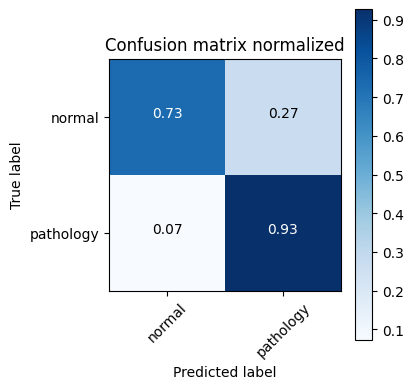

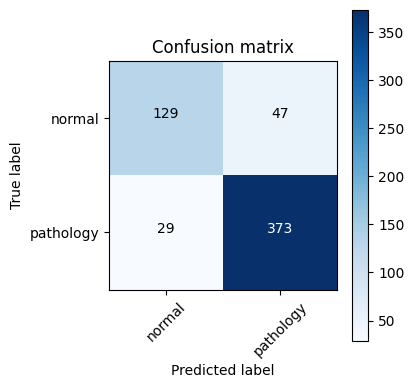

In [28]:
plt.figure(figsize=(4,4))
cm = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(cm, list(classes.keys()), normalize=True, title='Confusion matrix normalized')

plt.figure(figsize=(4,4))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.82      0.73      0.77       176
           1       0.89      0.93      0.91       402

    accuracy                           0.87       578
   macro avg       0.85      0.83      0.84       578
weighted avg       0.87      0.87      0.87       578

